# Limpieza de datos con PySpark: Data Science Job Posting on Glassdoor

Los [datos](https://tajamar365.sharepoint.com/:x:/s/3405-MasterIA2024-2025/ETYTQ0c-i6FLjM8rZ4iT1cgB6ipFAkainM-4V9M8DXsBiA?e=PeMtvh) fueron extraídos (scrapeados) del sitio web de Glassdoor y recoge los salarios de distintos puestos relacionados a Data.

### Resolver los siguientes requerimientos, para cada operación/moficación imprima como van quedadndo los cambios.

## Cargo el csv en un dataframe para poder trabajar sobre él.

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns

spark = (
    SparkSession
    .builder
    .appName('Caso_4')
    .getOrCreate()
)

df = spark.read.option("header", "true") \
               .option("delimiter", ";") \
               .option("multiline", "true") \
               .csv("/FileStore/Caso_4/ds_jobs.csv")

1. Cargar los datos y mostrar el esquema o la informacion de las columnas y el tip de dato de cada columna

In [0]:
print("Esquema:")
df.printSchema()

Esquema:
root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)



2. Eliminar duplicados

In [0]:
print("\nRegistros antes de eliminar duplicados:", df.count())

df = df.dropDuplicates()
print("\nRegistros después de eliminar duplicados:", df.count())


Registros antes de eliminar duplicados: 1009

Registros después de eliminar duplicados: 857


3. Decidir que hacer con los datos faltantes 

In [0]:
# Veo cuantos valores nulos hay por columna 
for columna in df.columns:
    conteo_nulos = df.filter(col(columna).isNull() | (col(columna) == "")).count()
    print(f"Nulos en {columna}: {conteo_nulos}")

# Reemplazo valores vacíos con None
df = df.select([when(col(c) == "", None).otherwise(col(c)).alias(c) for c in df.columns])

Nulos en index: 0
Nulos en Job Title: 135
Nulos en Salary Estimate: 136
Nulos en Job Description: 136
Nulos en Rating: 188
Nulos en Company Name: 188
Nulos en Location: 188
Nulos en Headquarters: 188
Nulos en Size: 188
Nulos en Founded: 188
Nulos en Type of ownership: 188
Nulos en Industry: 188
Nulos en Sector: 227
Nulos en Revenue: 229
Nulos en Competitors: 230


4. Decidir que hacer con los valores nulos

In [0]:
from pyspark.sql.functions import trim, regexp_extract, col

# Primero creo una función para ver cuantos nulos hay por columna
def mostrar_nulos_por_columna(df, nombre_df):
    print(f"\n=== Conteo de nulos en {nombre_df} ===")
    for columna in df.columns:
        conteo_nulos = df.filter(col(columna).isNull() | (col(columna) == "")).count()
        print(f"Nulos en {columna}: {conteo_nulos}")
    print("=" * 50)

# Muestro el conteo del df original antes del proceso de eliminar nulos
filas_originales = df.count()
print("\n=== Inicio del proceso de limpieza ===")
print(f"Número de filas originales: {filas_originales}")
print("=" * 50)

# 1. Al hacer un display del df he visto que había un montón de registros con strings en la columna "index" por lo que toda fila que tenga algo que no sea un número en ella la voy a eliminar.
df_indices_limpios = df.filter(
    regexp_extract(trim(df['index']), '^\d+$', 0) != ''
)
mostrar_nulos_por_columna(df_indices_limpios, "df_indices_limpios")

# Los siguientes dos filtros se podrían hacer comprobando todas las columnas en búsqueda de nulos y eliminar las resultantes. Pero comprobando sólo una, reduzco el tiempo y la carga de trabajo (Creo)

# 2. Después de la limpieza anterior quedaban nulos en la columna "Rating" y otras, pero casualmente en la mayoría eran 53, por lo que he supuesto que coincidían, por lo que quitandome los nulos de rating también desaparecerían muchos o todos los de las otras columnas.
df_sin_ratings_nulos = df_indices_limpios.filter(
    col('Rating').isNotNull()
)
mostrar_nulos_por_columna(df_sin_ratings_nulos, "df_sin_ratings_nulos")

# 3. Después del filtro anterior se puede ver que aún hay dos columnas con un nulo cada una, por lo que también he aplicado la forma de pensar anterior y he supuesto que ambos nulos estaban en la misma fila, así que eliminando los nulos de "Salary Estimate" también me quitaría el de "Job Description".
df_sin_salarios_nulos = df_sin_ratings_nulos.filter(
    col('Salary Estimate').isNotNull()
)
mostrar_nulos_por_columna(df_sin_salarios_nulos, "df_sin_salarios_nulos")

# Replico por pantalla el proceso
print("\n=== Resumen del proceso de limpieza ===")
print(f"Filas originales: {filas_originales}")
print(f"Filas después de limpiar índices: {df_indices_limpios.count()} " + 
      f"(-{filas_originales - df_indices_limpios.count()})")
print(f"Filas después de eliminar ratings nulos: {df_sin_ratings_nulos.count()} " + 
      f"(-{df_indices_limpios.count() - df_sin_ratings_nulos.count()})")
print(f"Filas después de eliminar salarios nulos: {df_sin_salarios_nulos.count()} " + 
      f"(-{df_sin_ratings_nulos.count() - df_sin_salarios_nulos.count()})")
print("=" * 50)

df = df_sin_salarios_nulos


=== Inicio del proceso de limpieza ===
Número de filas originales: 857

=== Conteo de nulos en df_indices_limpios ===
Nulos en index: 0
Nulos en Job Title: 0
Nulos en Salary Estimate: 1
Nulos en Job Description: 1
Nulos en Rating: 53
Nulos en Company Name: 53
Nulos en Location: 53
Nulos en Headquarters: 53
Nulos en Size: 53
Nulos en Founded: 53
Nulos en Type of ownership: 53
Nulos en Industry: 53
Nulos en Sector: 53
Nulos en Revenue: 53
Nulos en Competitors: 53

=== Conteo de nulos en df_sin_ratings_nulos ===
Nulos en index: 0
Nulos en Job Title: 0
Nulos en Salary Estimate: 1
Nulos en Job Description: 1
Nulos en Rating: 0
Nulos en Company Name: 0
Nulos en Location: 0
Nulos en Headquarters: 0
Nulos en Size: 0
Nulos en Founded: 0
Nulos en Type of ownership: 0
Nulos en Industry: 0
Nulos en Sector: 0
Nulos en Revenue: 0
Nulos en Competitors: 0

=== Conteo de nulos en df_sin_salarios_nulos ===
Nulos en index: 0
Nulos en Job Title: 0
Nulos en Salary Estimate: 0
Nulos en Job Description: 0
N

5. ¿Cuántos registros tiene el csv?

In [0]:
print("\nTotal de registros:", df.count())


Total de registros: 624


6. Mostrar los valores únicos de `Job title` 

In [0]:
print("\nValores únicos de Título de Trabajo:")
df.select("Job Title").distinct().show(truncate=False)


Valores únicos de Título de Trabajo:
+----------------------------------------------+
|Job Title                                     |
+----------------------------------------------+
|Business Intelligence Analyst                 |
|Data Modeler                                  |
|Senior Research Statistician- Data Scientist  |
|Sr Data Scientist                             |
|Data Scientist/Machine Learning               |
|Data Scientist / Machine Learning Expert      |
|Associate Data Scientist                      |
|Medical Lab Scientist                         |
|Human Factors Scientist                       |
|Experienced Data Scientist                    |
|Data Analyst II                               |
|Data Scientist                                |
|Data Analyst                                  |
|Senior Analyst/Data Scientist                 |
|Data Scientist-Human Resources                |
|Data Scientist - Contract                     |
|Data Scientist - Risk         

7. Remover la letra `K` de la columna `Salary Estimate` y multiplicar por 1000.

In [0]:
df = df.withColumn("Salary Estimate", 
    regexp_replace("Salary Estimate", "K", "000")
)

df.select("Salary Estimate").show()

+--------------------+
|     Salary Estimate|
+--------------------+
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
|$137000-$171000 (...|
+--------------------+
only showing top 20 rows



8. Mostrar los valores únicos del campo `Salary Estimate`

In [0]:
print("\nValores únicos:")
df.select("Salary Estimate").distinct().show(truncate=False)


Valores únicos:
+--------------------------------+
|Salary Estimate                 |
+--------------------------------+
|$79000-$106000 (Glassdoor est.) |
|$141000-$225000 (Glassdoor est.)|
|$112000-$116000 (Glassdoor est.)|
|$31000-$56000 (Glassdoor est.)  |
|$56000-$97000 (Glassdoor est.)  |
|$145000-$225000(Employer est.)  |
|$122000-$146000 (Glassdoor est.)|
|$101000-$165000 (Glassdoor est.)|
|$79000-$133000 (Glassdoor est.) |
|$99000-$132000 (Glassdoor est.) |
|$79000-$131000 (Glassdoor est.) |
|$90000-$109000 (Glassdoor est.) |
|$69000-$116000 (Glassdoor est.) |
|$79000-$147000 (Glassdoor est.) |
|$90000-$124000 (Glassdoor est.) |
|$91000-$150000 (Glassdoor est.) |
|$137000-$171000 (Glassdoor est.)|
|$71000-$123000 (Glassdoor est.) |
|$110000-$163000 (Glassdoor est.)|
|$75000-$131000 (Glassdoor est.) |
+--------------------------------+
only showing top 20 rows



9. Eliminar `(Glassdoor est.)` y `(Employer est.)` del campo `Salary Estimate`

In [0]:
df = df.withColumn("Salary Estimate",
    regexp_replace(
        regexp_replace("Salary Estimate", r"\(Glassdoor est.\)", ""),
        r"\(Employer est.\)", ""
    )
)

df.select("Salary Estimate").show(truncate=False)

+----------------+
|Salary Estimate |
+----------------+
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
|$137000-$171000 |
+----------------+
only showing top 20 rows



10. Mostrar de mayor a menor los valores del campo `Salary Estimate`

In [0]:
print("\nEstimación de Salario ordenado:")
df.orderBy(desc("Salary Estimate")).select("Salary Estimate").show()


Estimación de Salario ordenado:
+---------------+
|Salary Estimate|
+---------------+
|              0|
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
|$99000-$132000 |
+---------------+
only showing top 20 rows



11. De la columna `Job Description` quitar los saltos de linea `\n` del texto

In [0]:
df = df.withColumn("Job Description", regexp_replace("Job Description", r"\n", " "))

df.select("Job Description").show(2, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

12. De la columna `Rating` muestre los valores unicos.

In [0]:
print("\nValores únicos de Calificación:")
df.select("Rating").distinct().show()


Valores únicos de Calificación:
+------+
|Rating|
+------+
|    29|
|    42|
|    34|
|    28|
|    22|
|    35|
|    47|
|    43|
|    31|
|    27|
|    41|
|    38|
|    44|
|    33|
|    48|
|    32|
|    36|
|    37|
|    39|
|    50|
+------+
only showing top 20 rows



13. Del campo `Rating` reemplazar los `-1.0` por `0.0`.

In [0]:
# No sé si hay que cambiar también los -1, si es así sería: when(col("Rating").isin("-1.0", "-1"), "0.0").otherwise(col("Rating"))
df = df.withColumn("Rating", 
    when(col("Rating") == "-1.0", "0.0").otherwise(col("Rating"))
)

df.select("Rating").show(5, truncate=False)

+------+
|Rating|
+------+
|35    |
|-1    |
|49    |
|37    |
|-1    |
+------+
only showing top 5 rows



14. Mostrar los valores unicos y ordenar los valores del campo `Company Name`.

In [0]:
print("\nValores únicos de Nombre de Empresa ordenados:")
df.select("Company Name").distinct().orderBy("Company Name").show()


Valores únicos de Nombre de Empresa ordenados:
+--------------------+
|        Company Name|
+--------------------+
|                   0|
|  1-800-Flowers\n2.7|
|       1010data\n3.1|
|       1904labs\n4.7|
|22nd Century Tech...|
|     7Park Data\n3.9|
|A Place for Mom\n2.7|
|A-Line Staffing S...|
|        ABIOMED\n4.1|
|ALTA IT Services\...|
|ASRC Federal Hold...|
|          AccessHope|
|Acuity Insurance\...|
|Advance Sourcing ...|
|Advanced Bio-Logi...|
|Advanced BioScien...|
|Adwait Algorithm\...|
|  AeroVironment\n4.2|
|Affinity Solution...|
|AgreeYa Solutions...|
+--------------------+
only showing top 20 rows



15. Quitar todos los caracteres innecesarios que encuentres en el campo `Company Name`. Por ejemplo los saltos de linea `\n`

In [0]:
df = df.withColumn("Company Name", 
    regexp_replace(regexp_replace("Company Name", r"\n.*", ""), r"\\n", "")
)

df.select("Company Name").show(5, truncate=False)

+------------------+
|Company Name      |
+------------------+
|INFICON           |
|Healthfirst       |
|Affinity Solutions|
|ManTech           |
|HG Insights       |
+------------------+
only showing top 5 rows



16. En el campo `Location` convertir esa columna en dos: `City` y `State`. Las ciudades que tengas en `Location` asignar a la columna `City`. Lo mismo para `State`. Luego elimine la columna `Location`.

In [0]:
df = df.withColumn("Ciudad", split("Location", ",").getItem(0)) \
       .withColumn("Estado", trim(split("Location", ",").getItem(1))) \
       .drop("Location")

df.show(5)

+-----+--------------------+---------------+--------------------+------+-------------------+--------------------+--------------------+-------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------+------+
|index|           Job Title|Salary Estimate|     Job Description|Rating|       Company Name|        Headquarters|                Size|Founded|Type of ownership|            Industry|              Sector|             Revenue|         Competitors|       Ciudad|Estado|
+-----+--------------------+---------------+--------------------+------+-------------------+--------------------+--------------------+-------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------+------+
|   56|Senior Data Scien...|$75000-$131000 |Benson Hill empow...|    35|        Benson Hill|     Saint Louis, MO|201 to 500 employees|   2012|Company - Private|Biotech & Pharmac...|Biotech & Pharmac...|

17. Repetir la misma lógica de la pregunta 16 pero para el campo `Headquarters`. En Headquarters dejar solo la ciudad, mientras que para el estado añadirla a una columna nueva ` Headquarter State`.

In [0]:
df = df.withColumn("Ciudad_Sede", split("Headquarters", ",").getItem(0)) \
       .withColumn("Estado_Sede", trim(split("Headquarters", ",").getItem(1))) \
       .drop("Headquarters")

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------+----------------+-----------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|       Ciudad|Estado|     Ciudad_Sede|Estado_Sede|
+-----+--------------------+----------------+--------------------+------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------+----------------+-----------+
|   56|Senior Data Scien...| $75000-$131000 |Benson Hill empow...|    35|         Benson Hill|201 to 500 employees|   2012|   Company - Private|Biotech & Pharmac..

18. Muestre los valores únicos del campo `Headquarter State` 

In [0]:
print("\nValores únicos de Estado de la Sede:")
df.select("Estado_Sede").distinct().show()


Valores únicos de Estado de la Sede:
+-----------+
|Estado_Sede|
+-----------+
|         AZ|
|         LA|
|  Singapore|
|         NJ|
|         DC|
|         VA|
|         WI|
|         CA|
|         NE|
|         MO|
|         IL|
|         WA|
|         OH|
|         TN|
|         PA|
|         NY|
|Switzerland|
|         GA|
|      Japan|
|         MA|
+-----------+
only showing top 20 rows



19. Mostrar valores unicos del campo `Size`.

In [0]:
print("\nValores únicos de Tamaño:")
df.select("Size").distinct().show()


Valores únicos de Tamaño:
+--------------------+
|                Size|
+--------------------+
|                  -1|
|5001 to 10000 emp...|
|                   0|
|             Unknown|
| 51 to 200 employees|
|1001 to 5000 empl...|
|501 to 1000 emplo...|
|201 to 500 employees|
|    10000+ employees|
|   1 to 50 employees|
+--------------------+



20. Quitar 'employee' de los registros del campo `Size`. Elimine tambien otros caracteres basura.

In [0]:
df = df.withColumn("Size", 
    regexp_replace(regexp_replace("Size", "employees", ""), r"\s+", " ")
)

df.select("Size").show(5)

+--------------+
|          Size|
+--------------+
|  501 to 1000 |
| 1001 to 5000 |
|    51 to 200 |
|5001 to 10000 |
|    51 to 200 |
+--------------+
only showing top 5 rows



21. Reemplazar la palabra 'to' por '-' en todos los registros del campo `Size`. Reemplazar tambien '-1' por 'Unknown'. 

In [0]:
df = df.withColumn("Size", 
    when(col("Size") == "-1", "Unknown")
    .otherwise(regexp_replace("Size", "to", "-"))
)

df.select("Size").show()

+-------------+
|         Size|
+-------------+
|   201 - 500 |
|      Unknown|
|   201 - 500 |
| 1001 - 5000 |
|      1 - 50 |
|    51 - 200 |
|5001 - 10000 |
|  501 - 1000 |
|      1 - 50 |
|    51 - 200 |
|   201 - 500 |
|   201 - 500 |
|      1 - 50 |
| 1001 - 5000 |
|  501 - 1000 |
| 1001 - 5000 |
|  501 - 1000 |
|   201 - 500 |
|    51 - 200 |
| 1001 - 5000 |
+-------------+
only showing top 20 rows



22. Mostrar el tipo de dato del campo `Type of ownership` y sus registros unicos.

In [0]:
print("\nTipo de dato de Tipo de Propiedad:")
df.select("Type of ownership").printSchema()
print("\nValores únicos:")
df.select("Type of ownership").distinct().show()


Tipo de dato de Tipo de Propiedad:
root
 |-- Type of ownership: string (nullable = true)


Valores únicos:
+--------------------+
|   Type of ownership|
+--------------------+
|                  -1|
|          Government|
|Subsidiary or Bus...|
|       Self-employed|
|            Contract|
|             Unknown|
|   Company - Private|
|Nonprofit Organiz...|
|            Hospital|
|Private Practice ...|
|    Company - Public|
|  Other Organization|
+--------------------+



23. Cambiar '-1' por 'Unknown' en todos los registros del campo `Type of ownership`.

In [0]:
df = df.withColumn("Type of ownership",
    when(col("Type of ownership") == "-1", "Unknown")
    .otherwise(col("Type of ownership"))
)

df.select("Type of ownership").show()

+--------------------+
|   Type of ownership|
+--------------------+
|   Company - Private|
|   Company - Private|
|   Company - Private|
|          Government|
|   Company - Private|
|   Company - Private|
|Nonprofit Organiz...|
|Subsidiary or Bus...|
|   Company - Private|
|   Company - Private|
|   Company - Private|
|   Company - Private|
|             Unknown|
|   Company - Private|
|   Company - Private|
|Nonprofit Organiz...|
|   Company - Private|
|   Company - Private|
|    Company - Public|
|   Company - Private|
+--------------------+
only showing top 20 rows



24. Cambiar:  
-  `Company - Public` por `Public Company`  
-  `Company - Private` por `Private Company`  
-  `Private Practice / Firm` por `Private Company`  
-  `Subsidiary or Business Segment` por `Business`  
-  `College / University` por `Education`  
En todos los registros del campo `Type of ownership`.

In [0]:
mapeo_propiedad = {
    "Company - Public": "Empresa Pública",
    "Company - Private": "Empresa Privada",
    "Private Practice / Firm": "Empresa Privada",
    "Subsidiary or Business Segment": "Negocio",
    "College / University": "Educación"
}

for antiguo, nuevo in mapeo_propiedad.items():
    df = df.withColumn("Type of ownership",
        when(col("Type of ownership") == antiguo, nuevo)
        .otherwise(col("Type of ownership"))
    )

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------+----------------+-----------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|       Ciudad|Estado|     Ciudad_Sede|Estado_Sede|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------+----------------+-----------+
|   56|Senior Data Scien...| $75000-$131000 |Benson Hill empow...|    35|         Benson Hill|   201 - 500 |   2012|     Empresa Privada|Biotech & Pharmac...|Biotech & Pharmac...|$1 to

25. Mostrar el tipo de dato y los valores unicos del campo `Industry`.

In [0]:
print("\nTipo de dato de Industria:")
df.select("Industry").printSchema()
print("\nValores únicos:")
df.select("Industry").distinct().show()


Tipo de dato de Industria:
root
 |-- Industry: string (nullable = true)


Valores únicos:
+--------------------+
|            Industry|
+--------------------+
|                  -1|
|Investment Bankin...|
|  Insurance Carriers|
|              Energy|
|Advertising & Mar...|
|         IT Services|
|Chemical Manufact...|
|Enterprise Softwa...|
|            Internet|
|Electrical & Elec...|
|Express Delivery ...|
|           Utilities|
|Biotech & Pharmac...|
|Staffing & Outsou...|
|Research & Develo...|
|          Consulting|
|    Federal Agencies|
|Computer Hardware...|
|Consumer Electron...|
| Aerospace & Defense|
+--------------------+
only showing top 20 rows



26. En el mismo campo de `Industry` reemplazar '-1' por 'Not Available' y '&' por 'and'.  Vuelva a imprimir los valores unicos en orden alfabético.

In [0]:
df = df.withColumn("Industry",
    when(col("Industry") == "-1", "Not Available")
    .otherwise(regexp_replace("Industry", "&", "and"))
)

df = df.orderBy(col("Industry").asc())

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+------------+-------+-----------------+--------------------+------------------+--------------------+--------------------+-------------+------+-----------+-----------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|        Size|Founded|Type of ownership|            Industry|            Sector|             Revenue|         Competitors|       Ciudad|Estado|Ciudad_Sede|Estado_Sede|
+-----+--------------------+----------------+--------------------+------+--------------------+------------+-------+-----------------+--------------------+------------------+--------------------+--------------------+-------------+------+-----------+-----------+
|  422|      Data Scientist|$124000-$198000 |Job Description J...|    45|Conflux Systems Inc.|     1 - 50 |     -1|  Empresa Privada|          Accounting|Accounting & Legal|Less than $1 mill...|                  -1|  

27. Para el campo `Sector`, muestre el tipo de dato y los valores únicos.

In [0]:
print("\nTipo de dato de Sector:")
df.select("Sector").printSchema()
print("\nValores únicos:")
df.select("Sector").distinct().show()


Tipo de dato de Sector:
root
 |-- Sector: string (nullable = true)


Valores únicos:
+--------------------+
|              Sector|
+--------------------+
|         Health Care|
|                  -1|
|           Insurance|
|Information Techn...|
|          Government|
|Oil, Gas, Energy ...|
|             Finance|
|         Real Estate|
|          Non-Profit|
|Construction, Rep...|
|               Media|
|Biotech & Pharmac...|
|  Telecommunications|
|  Accounting & Legal|
|    Travel & Tourism|
| Aerospace & Defense|
|   Business Services|
|Agriculture & For...|
|              Retail|
|       Manufacturing|
+--------------------+
only showing top 20 rows



28. Aplica la misma lógica de la pregunta 26 pero sobre el campo `Sector`.

In [0]:
df = df.withColumn("Sector",
    when(col("Sector") == "-1", "No Disponible")
    .otherwise(regexp_replace("Sector", "&", "y"))
)

df = df.orderBy(col("Sector").asc())

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------+------+-----------+-----------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|   Type of ownership|            Industry|             Sector|             Revenue|         Competitors|       Ciudad|Estado|Ciudad_Sede|Estado_Sede|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------+------+-----------+-----------+
|  422|      Data Scientist|$124000-$198000 |Job Description J...|    45|Conflux Systems Inc.|      1 - 50 |     -1|     Empresa Privada|          Accounting| Accounting y Legal|Less than $1 mill...|   

29. Para el campo `Revenue`, muestre el tipo de dato y los valores únicos en orden ascedente.

In [0]:
print("\nTipo de dato de Ingresos:")
df.select("Revenue").printSchema()
print("\nValores únicos ordenados (ascendente):")
df.select("Revenue").distinct().orderBy(col("Revenue").asc()).show()



Tipo de dato de Ingresos:
root
 |-- Revenue: string (nullable = true)


Valores únicos ordenados (ascendente):
+--------------------+
|             Revenue|
+--------------------+
|$1 to $2 billion ...|
|$1 to $5 million ...|
|$10 to $25 millio...|
|  $10+ billion (USD)|
|$100 to $500 mill...|
|$2 to $5 billion ...|
|$25 to $50 millio...|
|$5 to $10 billion...|
|$5 to $10 million...|
|$50 to $100 milli...|
|$500 million to $...|
|                  -1|
|                   0|
|Less than $1 mill...|
|Unknown / Non-App...|
+--------------------+



30. En el campo `Revenue`, cambiar:  
-  `-1` por `N/A`  
-  `Unknown / Non-Applicable` por `N/A`  
-  `Less than $1 million (USD)` por `Less than 1`
-  Quitar `$` y `(USD)`

In [0]:
df = df.withColumn("Revenue",
    when(col("Revenue") == "-1", "N/D")
    .when(col("Revenue") == "Unknown / Non-Applicable", "N/D")
    .when(col("Revenue") == "Less than $1 million (USD)", "Menos de 1")
    .otherwise(
        regexp_replace(
            regexp_replace("Revenue", r"\$", ""),
            r"\(USD\)", ""
        )
    )
)

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------+------+-----------+-----------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|   Type of ownership|            Industry|             Sector|             Revenue|         Competitors|       Ciudad|Estado|Ciudad_Sede|Estado_Sede|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------+------+-----------+-----------+
|  422|      Data Scientist|$124000-$198000 |Job Description J...|    45|Conflux Systems Inc.|      1 - 50 |     -1|     Empresa Privada|          Accounting| Accounting y Legal|          Menos de 1|   

31. Borrar el campo `Competitors`.

In [0]:
df = df.drop("Competitors")

df.printSchema()

root
 |-- index: string (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: string (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Ciudad: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- Ciudad_Sede: string (nullable = true)
 |-- Estado_Sede: string (nullable = true)



32. Crear tres columnas: `min_salary` (salario mínimo), `max_salary` (salario maximo) y `avg_salary` (salario promedio) a partir de los datos del campo `Salary Estimate`.

In [0]:
df = df.withColumn("texto_salario", regexp_replace("Salary Estimate", r"[^0-9-]", ""))

df = df.withColumn("salario_minimo", 
    split("texto_salario", "-").getItem(0).cast("int")) \
    .withColumn("salario_maximo", 
    split("texto_salario", "-").getItem(1).cast("int")) \
    .withColumn("salario_promedio",
    (col("salario_minimo") + col("salario_maximo")) / 2)

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|Type of ownership|            Industry|             Sector|             Revenue|        Ciudad|Estado|Ciudad_Sede|Estado_Sede|texto_salario|salario_minimo|salario_maximo|salario_promedio|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+
|  422|      Data Scientist|$124000-$198000 |Job Description J...|    45|Conflux Systems

33. Mostrar los valores unicos del campo `Founded` y el tipo de dato.

In [0]:
print("\nTipo de dato de Fundación:")
df.select("Founded").printSchema()
print("\nValores únicos:")
df.select("Founded").distinct().show()


Tipo de dato de Fundación:
root
 |-- Founded: string (nullable = true)


Valores únicos:
+-------+
|Founded|
+-------+
|   2016|
|   2012|
|   1988|
|   2017|
|   2014|
|   2000|
|   1965|
|   1981|
|   1968|
|   1967|
|   2011|
|   1997|
|   1973|
|   1996|
|   1983|
|   2015|
|   1998|
|   1993|
|   2010|
|   1990|
+-------+
only showing top 20 rows



34. Reemplazar '-1' por '2024' en todos los registros del campo `Founded`.

In [0]:
df = df.withColumn("Founded",
    when(col("Founded") == "-1", "2024")
    .otherwise(col("Founded"))
)

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|Type of ownership|            Industry|             Sector|             Revenue|        Ciudad|Estado|Ciudad_Sede|Estado_Sede|texto_salario|salario_minimo|salario_maximo|salario_promedio|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+
|  422|      Data Scientist|$124000-$198000 |Job Description J...|    45|Conflux Systems

35. Crear una nueva columna o campo que se llame `company_age` con los datos que se deducen del campo `Founded`.

In [0]:
df = df.withColumn("edad_empresa",
    2024 - col("Founded").cast("int")
)

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+------------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|Type of ownership|            Industry|             Sector|             Revenue|        Ciudad|Estado|Ciudad_Sede|Estado_Sede|texto_salario|salario_minimo|salario_maximo|salario_promedio|edad_empresa|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+------------+
|  422|      Data Scientist|$124000-$198000 |Job 

36. Crear una columna o campo que se llame: `Job Type` y en cada registro debe ir Senior, Junior o NA según los datos del campo `Job Title`.  
- Cambiar 'sr' o 'senior' o 'lead' o 'principal' por `Senior` en el campo `Job Type`. No olvidar las mayúsculas.
- Cambiar 'jr' o 'jr.' o cualquier otra variante por `Junior`.  
- En cualquier otro caso distinto a los anteriores añadir NA.

In [0]:
df = df.withColumn("tipo_trabajo",
    when(
        lower(col("Job Title")).rlike("sr|senior|lead|principal"), "Senior"
    ).when(
        lower(col("Job Title")).rlike("jr|junior"), "Junior"
    ).otherwise("NA")
)

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+------------+------------+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|Type of ownership|            Industry|             Sector|             Revenue|        Ciudad|Estado|Ciudad_Sede|Estado_Sede|texto_salario|salario_minimo|salario_maximo|salario_promedio|edad_empresa|tipo_trabajo|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+------------+------------+
|  422|   

37. Muestra los registros únicos del campo `Job Type`. 

In [0]:
print("\nValores únicos de Tipo de Trabajo:")
df.select("tipo_trabajo").distinct().show()


Valores únicos de Tipo de Trabajo:
+------------+
|tipo_trabajo|
+------------+
|      Senior|
|          NA|
|      Junior|
+------------+



38. Partiendo del campo `Job Description` se extraer todas o las principales skills solicitadas por las empresas, por ejemplo: Python, Spark , Big Data. Cada Skill debe ir en una nueva columna de tipo Binaria ( 0 , 1) o Booleana (True,  False) de modo que cada skill va ser una nueva columna y si esa skill es solicitada por la empresa colocar 1 sino colocar 0. Por ejemplo:  

Por ejemplo:  
| Job Title         | Salary Estimate | Job Description                                 | Rating | Company Name       | Size       | Founded | Type of ownership         | Industry                       | Sector                         | Same State      | company_age | Python | Excel |
|--------------------|-----------------|-------------------------------------------------|--------|--------------------|------------|---------|---------------------------|--------------------------------|--------------------------------|----------------|-------------|--------|-------|
| Sr Data Scientist | 137000-171000   | Description The Senior Data Scientist is resp... | 3.1    | Healthfirst        | 1001-5000  | 1993    | Nonprofit Organization    | Insurance Carriers            | Insurance Carriers            | Same State      | 31          | 0      | 0     |
| Data Scientist    | 137000-171000   | Secure our Nation, Ignite your Future Join th... | 4.2    | ManTech            | 5001-10000 | 1968    | Public Company            | Research and Development      | Research and Development      | Same State      | 56          | 0      | 0     |
| Data Scientist    | 137000-171000   | Overview Analysis Group is one of the larges... | 3.8    | Analysis Group      | 1001-5000  | 1981    | Private Company           | Consulting                    | Consulting                    | Same State      | 43          | 1      | 1     |
| Data Scientist    | 137000-171000   | JOB DESCRIPTION: Do you have a passion for Da... | 3.5    | INFICON            | 501-1000   | 2000    | Public Company            | Electrical and Electronic Manufacturing | Electrical and Electronic Manufacturing | Different State | 24          | 1      | 1     |


In [0]:
habilidades = ["Python", "SQL", "Excel", "Spark", "AWS", "Hadoop", "Java", "Scala", "R"]

for habilidad in habilidades:
    df = df.withColumn(
        habilidad,
        when(lower(col("Job Description")).contains(habilidad.lower()), 1).otherwise(0)
    )

df.show()

+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+-------------+--------------+--------------+----------------+------------+------------+------+---+-----+-----+---+------+----+-----+---+
|index|           Job Title| Salary Estimate|     Job Description|Rating|        Company Name|         Size|Founded|Type of ownership|            Industry|             Sector|             Revenue|        Ciudad|Estado|Ciudad_Sede|Estado_Sede|texto_salario|salario_minimo|salario_maximo|salario_promedio|edad_empresa|tipo_trabajo|Python|SQL|Excel|Spark|AWS|Hadoop|Java|Scala|  R|
+-----+--------------------+----------------+--------------------+------+--------------------+-------------+-------+-----------------+--------------------+-------------------+--------------------+--------------+------+-----------+-----------+

39. Exportar dataset final a csv

In [0]:
df.write.csv("/FileStore/Caso_4/datos_trabajos_limpios.csv", header=True, mode="overwrite")

In [0]:
df.display()

index Job Title Salary Estimate Job Description Rating Company Name Size Founded Type of ownership Industry Sector Revenue Ciudad Estado Ciudad_Sede Estado_Sede texto_salario salario_minimo salario_maximo salario_promedio edad_empresa tipo_trabajo Python SQL Excel Spark AWS Hadoop Java Scala R 422 Data Scientist $124000-$198000 Job Description Job Description for Data Scientist � 8+ years of experience as a data scientist. � Strong skills for mining data, assessing the accuracy and insights from new data sources. � Work with stakeholders to understand data challenges and opportunities � Experience building Machine Learning models for predictive analytics, and NLP. � Understanding of Deep Learning models is a plus � Experience with SQL � Master in Statistics, Computer Science, or other STEM field. Ph.D. is a plus. � Knowledge of advanced statistics and hypothesis testing � Python, Pandas, Numpy, Scikit coding skills � Data visualization with Matplotlib, and Seaborn � Experience with at least one cloud data technology GCP, AWS, Azure � Experience with Spark, and Hadoop is a plus. � Effective at telling stories with data. � Excellent written and verbal communication skills � Creative drive to try data tools, and explore and discover insights from data � NLP experience is MUST 45 Conflux Systems Inc. 1 - 50 2024 Empresa Privada Accounting Accounting y Legal Menos de 1 Winters TX Alpharetta GA 124000-198000 124000 198000 161000.0 0 NA 1 1 1 1 1 1 0 0 1 490 Data Scientist $95000-$119000 Use statistical analysis, machine learning, pattern recognition, and data visualization along with domain knowledge and subject-specific models to solve science, engineering, and commercial problems Solve challenging data science problems by developing novel and/or adapting existing computational methods Debugging and performance tweaking in Python Taking ownership over parts of an application and collaborating on global issues Understand and enjoy working in a micro services based architecture Hands-on experience in PostgreSQL, SQL Server, Oracle, RESTFul,GIT, API, JSON, Statistical Analysis, Machine Learning, Pattern Recognition, Knowledge in Data Visualization, Numpy, Pandas, Scipy, Matplotlib, Soup, Scrapy, Teradata,NoSQL, Redis, Elastic Search, Mongo, Django, Flask, Pyramid, SVN, Mercurial,Linear Algebra and Optimization Knowledge in Hypothesis Testing, Monte Carlo Simulation, Clustering 40 Lorven Technologies Inc 1 - 50 2024 Empresa Privada Accounting Accounting y Legal Menos de 1 New York NY Plainsboro NJ 95000-119000 95000 119000 107000.0 0 NA 1 1 0 0 0 0 0 0 1 605 Data Scientist $80000-$132000 Use statistical analysis, machine learning, pattern recognition, and data visualization along with domain knowledge and subject-specific models to solve science, engineering, and commercial problems Solve challenging data science problems by developing novel and/or adapting existing computational methods Debugging and performance tweaking in Python Taking ownership over parts of an application and collaborating on global issues Understand and enjoy working in a micro services based architecture Hands-on experience in PostgreSQL, SQL Server, Oracle, RESTFul,GIT, API, JSON, Statistical Analysis, Machine Learning, Pattern Recognition, Knowledge in Data Visualization, Numpy, Pandas, Scipy, Matplotlib, Soup, Scrapy, Teradata,NoSQL, Redis, Elastic Search, Mongo, Django, Flask, Pyramid, SVN, Mercurial,Linear Algebra and Optimization Knowledge in Hypothesis Testing, Monte Carlo Simulation, Clustering 40 Lorven Technologies Inc 1 - 50 2024 Empresa Privada Accounting Accounting y Legal Menos de 1 New York NY Plainsboro NJ 80000-132000 80000 132000 106000.0 0 NA 1 1 0 0 0 0 0 0 1 618 Data Scientist $87000-$141000 Position Description Data Scientist Location National Capital Region, VA Job Code 122 # of openings 1 Apply Now Overview: Based in Northern, VA, Axiologic Solutions LLC has opportunities for you to become part of our high-quality team that delivers innov

40. Extraer todos los insights posibles que sean de valor o utilidad. Cree nuevas columnas, agrupar,  filtrar hacer varios plots que muestren dichos insights que sean de utilidad para una empresa o para un usuario. Elabore conclusiones con los insights encontrados. 

In [0]:
# Salario promedio por tipo de trabajo
print("\nSalario promedio por tipo de trabajo:")
df.groupBy("tipo_trabajo").agg(
    avg("salario_promedio").alias("promedio_salario")
).show()

# Top 10 empresas con mejores calificaciones
print("\nTop 10 empresas con mejores calificaciones:")
df.select("Company Name", "Rating") \
  .orderBy(desc("Rating")) \
  .limit(10) \
  .show()

# Distribución de habilidades requeridas
print("\nDistribución de habilidades requeridas:")
for habilidad in habilidades:
    conteo = df.filter(col(habilidad) == 1).count()
    total = df.count()
    porcentaje = (conteo/total) * 100
    print(f"{habilidad}: {porcentaje:.2f}%")

# Promedio de salarios por industria
print("\nPromedio de salarios por industria:")
df.groupBy("Industry") \
  .agg(avg("salario_promedio").alias("promedio_salario")) \
  .orderBy(desc("promedio_salario")) \
  .show()

# Relación entre edad de la empresa y salario
print("\nCorrelación entre edad de la empresa y salario:")
correlacion = df.stat.corr("edad_empresa", "salario_promedio")
print(f"Correlación: {correlacion}")


Salario promedio por tipo de trabajo:
+------------+------------------+
|tipo_trabajo|  promedio_salario|
+------------+------------------+
|      Senior| 124344.8275862069|
|          NA|124138.57677902622|
|      Junior|           89750.0|
+------------+------------------+


Top 10 empresas con mejores calificaciones:
+--------------------+------+
|        Company Name|Rating|
+--------------------+------+
|Phoenix Operation...|    50|
|Phoenix Operation...|    50|
|    Genesis Research|    50|
| Arsenal Biosciences|    50|
|Phoenix Operation...|    50|
|        JCD Staffing|    50|
| Arsenal Biosciences|    50|
|              Maxiom|    50|
|         Notion Labs|    50|
|Phoenix Operation...|    50|
+--------------------+------+


Distribución de habilidades requeridas:
Python: 72.44%
SQL: 55.13%
Excel: 43.91%
Spark: 26.92%
AWS: 23.88%
Hadoop: 21.79%
Java: 24.84%
Scala: 23.40%
R: 99.84%

Promedio de salarios por industria:
+--------------------+------------------+
|            Indu

## Con gráficas

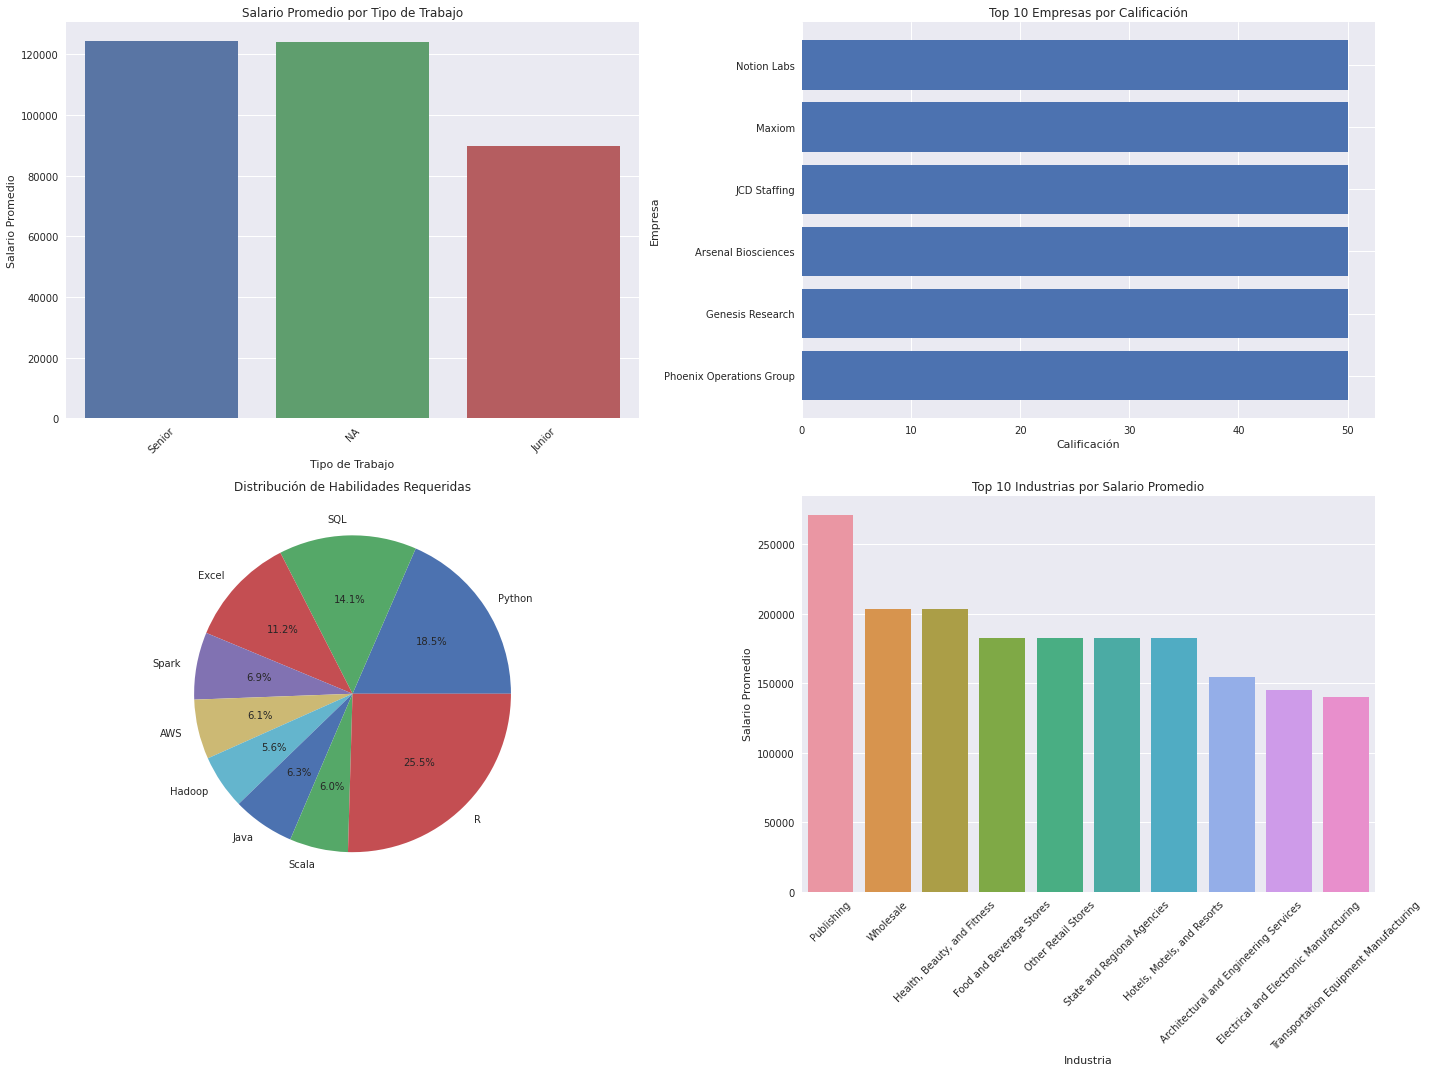

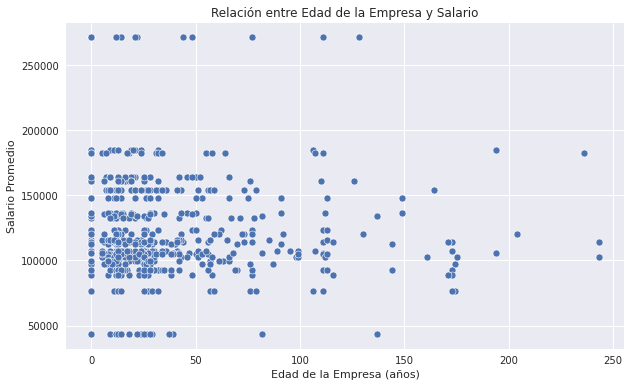

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convierto los resultados de Spark a Pandas para poder generar gráficos
# 1. Salarios por tipo de trabajo
salarios_trabajo_pd = df.groupBy("tipo_trabajo").agg(
    avg("salario_promedio").alias("promedio_salario")
).toPandas()

# 2. Top 10 empresas
top_empresas_pd = df.select("Company Name", "Rating") \
                   .orderBy(desc("Rating")) \
                   .limit(10) \
                   .toPandas()
# Me aseguro que Rating sea numérico
top_empresas_pd['Rating'] = pd.to_numeric(top_empresas_pd['Rating'], errors='coerce')

# 3. Distribución de habilidades
habilidades_dict = {}
for habilidad in habilidades:
    conteo = df.filter(col(habilidad) == 1).count()
    total = df.count()
    habilidades_dict[habilidad] = (conteo/total) * 100
habilidades_pd = pd.DataFrame(list(habilidades_dict.items()), columns=['Habilidad', 'Porcentaje'])

# 4. Salarios por industria
salarios_industria_pd = df.groupBy("Industry") \
                         .agg(avg("salario_promedio").alias("promedio_salario")) \
                         .orderBy(desc("promedio_salario")) \
                         .toPandas()


# A partir de aquí creo los gráficos
plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 15))

# 1. Gráfico de barras - Salarios por tipo de trabajo
plt.subplot(2, 2, 1)
sns.barplot(data=salarios_trabajo_pd, x='tipo_trabajo', y='promedio_salario')
plt.title('Salario Promedio por Tipo de Trabajo')
plt.xticks(rotation=45)
plt.ylabel('Salario Promedio')
plt.xlabel('Tipo de Trabajo')

# 2. Gráfico de barras horizontal - Top 10 empresas
plt.subplot(2, 2, 2)
# Ordeno por Rating de mayor a menor
top_empresas_pd = top_empresas_pd.sort_values('Rating', ascending=True)  # Ascending True para que la mejor calificación aparezca arriba
plt.barh(top_empresas_pd['Company Name'], top_empresas_pd['Rating'])
plt.title('Top 10 Empresas por Calificación')
plt.xlabel('Calificación')
plt.ylabel('Empresa')

# 3. Gráfico de pie - Distribución de habilidades
plt.subplot(2, 2, 3)
plt.pie(habilidades_pd['Porcentaje'], labels=habilidades_pd['Habilidad'], autopct='%1.1f%%')
plt.title('Distribución de Habilidades Requeridas')

# 4. Gráfico de barras - Salarios por industria
plt.subplot(2, 2, 4)
sns.barplot(data=salarios_industria_pd.head(10), x='Industry', y='promedio_salario')
plt.title('Top 10 Industrias por Salario Promedio')
plt.xticks(rotation=45)
plt.ylabel('Salario Promedio')
plt.xlabel('Industria')

plt.tight_layout()
display(plt.show())

# Gráfico adicional: Relación entre edad de la empresa y salario
plt.figure(figsize=(10, 6))
edad_salario_pd = df.select("edad_empresa", "salario_promedio").toPandas()
sns.scatterplot(data=edad_salario_pd, x='edad_empresa', y='salario_promedio')
plt.title('Relación entre Edad de la Empresa y Salario')
plt.xlabel('Edad de la Empresa (años)')
plt.ylabel('Salario Promedio')
display(plt.show())